<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/fusion_final_plan_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =============================================
# 1. CONFIGURACIÓN INICIAL Y LIBRERÍAS
# =============================================
!pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from kmodes.kprototypes import KPrototypes
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                           accuracy_score, classification_report, roc_auc_score,
                           precision_recall_curve, confusion_matrix)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import glob

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [4]:
# =============================================
# 2. CARGA Y LIMPIEZA DE DATOS (DEL PRIMER SCRIPT MEJORADO)
# =============================================
def load_and_clean(path):
    # Lectura robusta con múltiples encodings
    try:
        df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')
        except:
            df = pd.read_csv(path, encoding='ISO-8859-1', on_bad_lines='skip')

    # Normalizar columnas
    df.columns = (
        df.columns
        .str.replace('\ufeff', '', regex=False)
        .str.strip()
        .str.lower()
    )

    # Renombrar variantes de columnas clave
    rename_map = {
        'fechayhora': 'fecha y hora',
        'tipodesiniestro': 'tipo de siniestro',
        'fallecidoalosdias': 'fallecidos a los dias',
        'otrovehiculo': 'otro vehiculo',
        'lugardelsiniestro': 'lugar del siniestro'
    }

    for old, new in rename_map.items():
        if old in df.columns and new not in df.columns:
            df = df.rename(columns={old: new})

    # Limpieza de fecha y hora
    df['fecha y hora'] = (
        df['fecha y hora']
        .astype(str)
        .str.replace('#', '', regex=False)
        .str.replace('am|pm', '', case=False, regex=True)
        .str.strip()
    )
    df['fecha y hora'] = pd.to_datetime(df['fecha y hora'], errors='coerce')

    return df

# Carga de múltiples archivos
files = glob.glob('Datos_fallecidos_siniestros_*.csv')
df_list = []
for f in files:
    print(f"Cargando {f}...")
    tmp = load_and_clean(f)
    n_err = tmp['fecha y hora'].isna().sum()
    if n_err:
        print(f"  → Atención: {n_err} filas con Fecha y hora inválida (NaT)")
    df_list.append(tmp)

df = pd.concat(df_list, ignore_index=True)
print(f"\nTotal de filas combinadas: {len(df)}")

Cargando Datos_fallecidos_siniestros_2018.csv...
  → Atención: 320 filas con Fecha y hora inválida (NaT)
Cargando Datos_fallecidos_siniestros_2014.csv...
  → Atención: 312 filas con Fecha y hora inválida (NaT)
Cargando Datos_fallecidos_siniestros_2016.csv...
  → Atención: 268 filas con Fecha y hora inválida (NaT)
Cargando Datos_fallecidos_siniestros_2019.csv...
Cargando Datos_fallecidos_siniestros_2017.csv...
  → Atención: 281 filas con Fecha y hora inválida (NaT)

Total de filas combinadas: 2404


In [5]:
# =============================================
# 3. PREPROCESAMIENTO Y FEATURE ENGINEERING (COMBINADO)
# =============================================
# Extracción de características temporales
df['año'] = df['fecha y hora'].dt.year
df['mes'] = df['fecha y hora'].dt.month
df['hora'] = df['fecha y hora'].dt.hour
df['dia_semana'] = df['fecha y hora'].dt.day_name()
df['es_fin_de_semana'] = df['dia_semana'].isin(['Saturday', 'Sunday']).astype(int)
df['hora_categoria'] = pd.cut(df['hora'], bins=[0,6,12,18,24],
                             labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'],
                             include_lowest=True)

# Variable objetivo para clasificación (fallecimiento inmediato o dentro de 24 horas)
df['objetivo_clasificacion'] = np.where(df['fallecidos a los dias'] <= 1, 1, 0)

# Limpieza de valores faltantes
for col in ['vehiculo', 'departamento', 'sexo', 'tipo de siniestro',
            'jurisdiccion', 'rol', 'localidad']:
    if col in df.columns:
        df[col] = df[col].fillna('No especificado')

<ipython-input-10-e5b64f00ba4b>:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



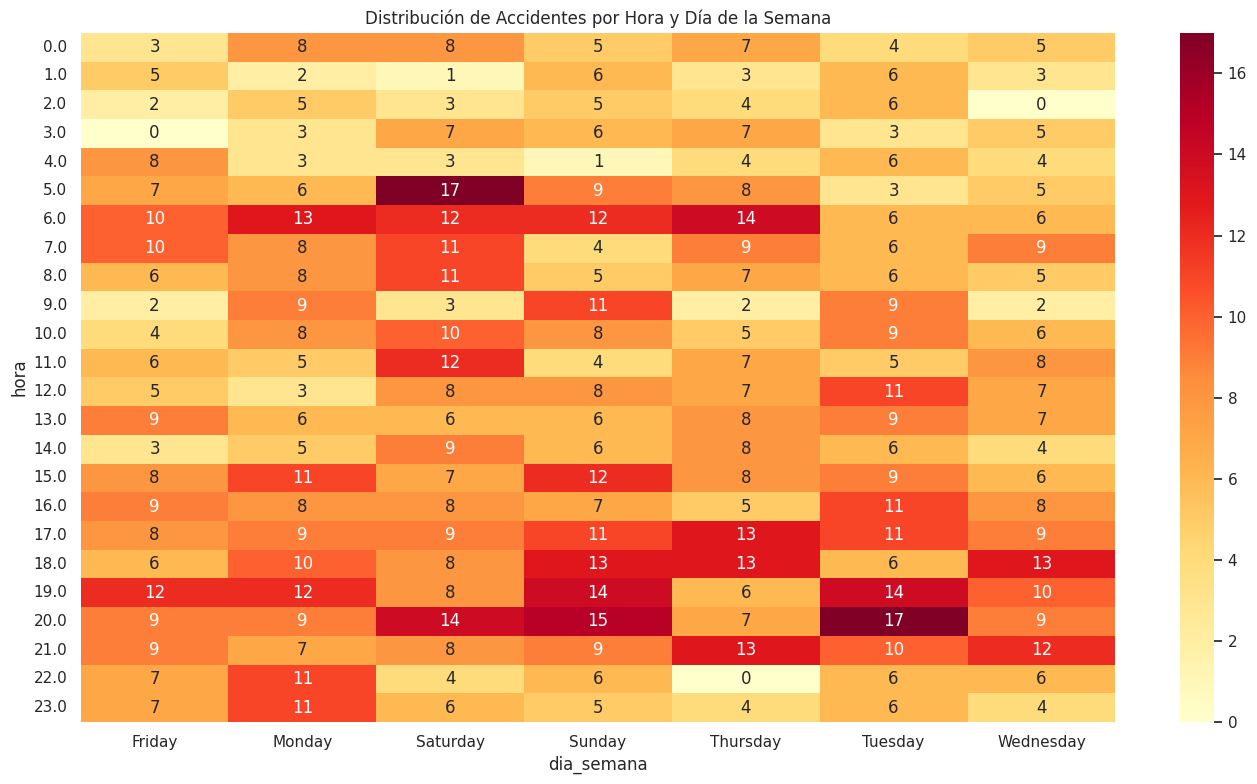

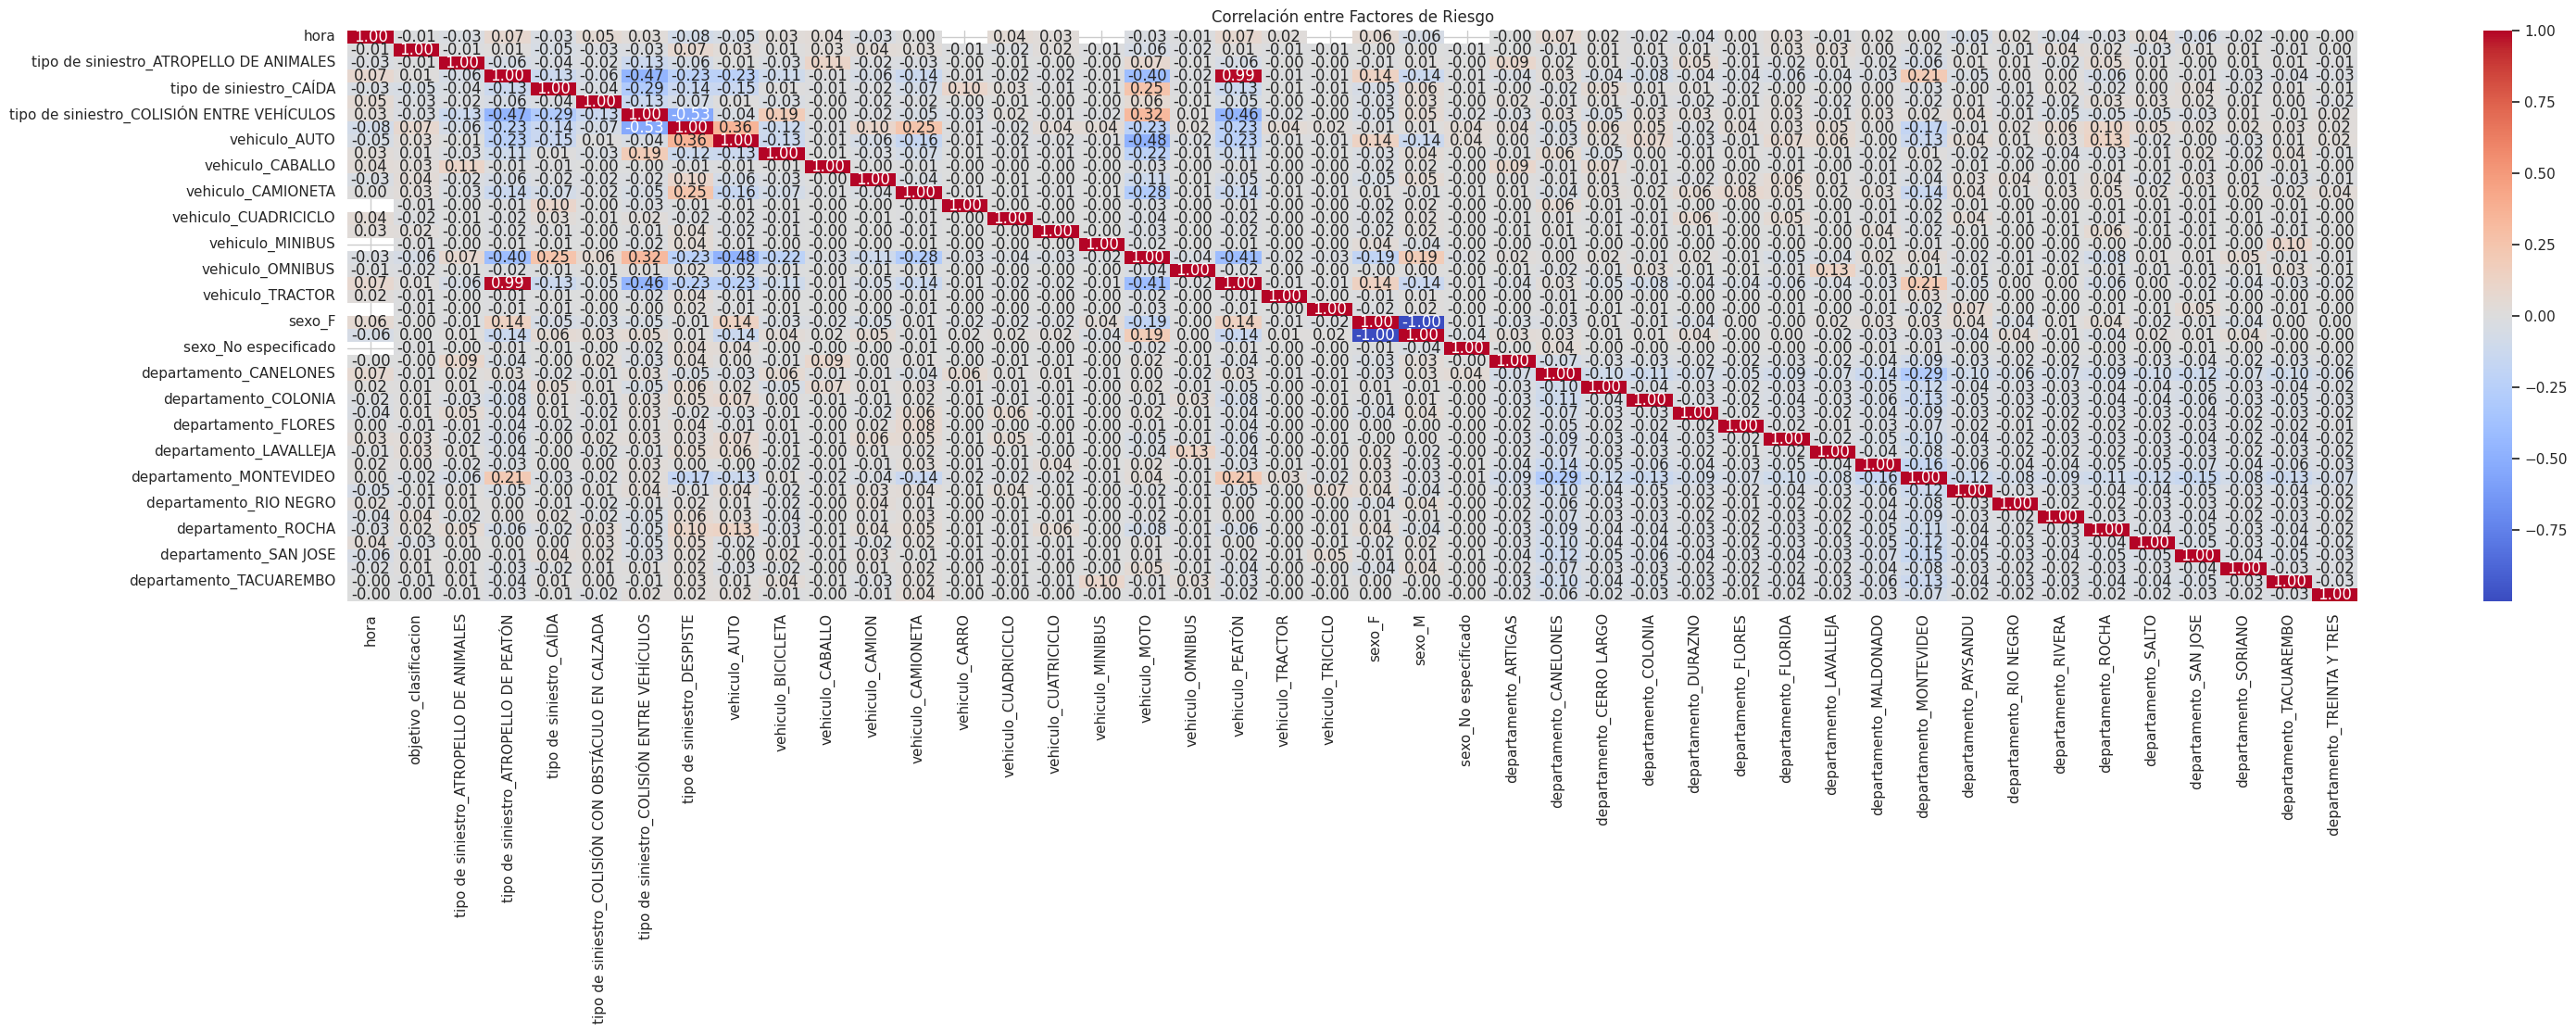

In [10]:
# =============================================
# 4. ANÁLISIS EXPLORATORIO (VISUALIZACIONES MEJORADAS)
# =============================================
def plot_interactive_trend(df):
    """Tendencia temporal interactiva con Plotly"""
    fig = px.line(df.resample('M', on='fecha y hora').size(),
                  title='Tendencia Mensual de Accidentes Fatales',
                  labels={'value': 'Número de fallecidos', 'fecha y hora': 'Fecha'})
    fig.update_layout(hovermode="x unified")
    fig.show()

def plot_heatmap_hora_dia(df):
    """Heatmap de accidentes por hora y día de la semana"""
    plt.figure(figsize=(14, 8))
    heatmap_data = df.pivot_table(index='hora', columns='dia_semana',
                                 values='objetivo_clasificacion', aggfunc='count',
                                 fill_value=0)
    sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt="d")
    plt.title('Distribución de Accidentes por Hora y Día de la Semana')
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    """Matriz de correlación de factores"""
    plt.figure(figsize=(35, 8))
    corr_matrix = df[['tipo de siniestro', 'vehiculo', 'sexo',
                      'departamento', 'hora', 'objetivo_clasificacion']]
    corr_matrix = pd.get_dummies(corr_matrix).corr()
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
    plt.title('Correlación entre Factores de Riesgo')
    plt.show()

# Ejecutar visualizaciones
plot_interactive_trend(df)
plot_heatmap_hora_dia(df)
plot_correlation_matrix(df)

In [11]:
# =============================================
# 5. MODELADO: K-PROTOTYPES
# =============================================
def run_kprototypes(df):
    """Ejecuta clustering con K-Prototypes"""
    # Definir columnas para clustering
    cols_cat = ['departamento', 'localidad', 'jurisdiccion', 'tipo de siniestro',
                'vehiculo', 'rol', 'sexo']
    cols_num = ['hora', 'edad', 'fallecidos a los dias']

    # Filtrar columnas existentes
    cols_cat = [c for c in cols_cat if c in df.columns]
    cols_num = [c for c in cols_num if c in df.columns]

    # Preparar datos
    data = df[cols_cat + cols_num].copy()

    # Imputación de valores faltantes
    for col in cols_num:
        median = data[col].median()
        data[col].fillna(median, inplace=True)
    for col in cols_cat:
        mode = data[col].mode()[0]
        data[col].fillna(mode, inplace=True)

    # Convertir a matriz numpy
    matrix = data.to_numpy()
    cat_pos = list(range(len(cols_cat)))

    # Entrenar modelo
    kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2, random_state=42)
    clusters = kproto.fit_predict(matrix, categorical=cat_pos)

    # Analizar clusters
    data['cluster'] = clusters
    for c in range(kproto.n_clusters):
        sub = data[data['cluster'] == c]
        print(f"\n=== Cluster {c} ===")
        print("Tamaño:", len(sub))
        print("Modo vehículo:", sub['vehiculo'].mode()[0])
        print("Modo tipo de siniestro:", sub['tipo de siniestro'].mode()[0])
        print("Hora promedio:", sub['hora'].mean().round(1))

    return clusters

df['cluster'] = run_kprototypes(df)


<ipython-input-11-4c806e7378fd>:21: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-11-4c806e7378fd>:24: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 577, ncost: 250107.5139670724
Run: 1, iteration: 2/100, moves: 327, ncost: 225441.9572923609
Run: 1, iteration: 3/100, moves: 205, ncost: 216597.2600600411
Run: 1, iteration: 4/100, moves: 120, ncost: 213312.63705328543
Run: 1, iteration: 5/100, moves: 88, ncost: 211736.30219469932
Run: 1, iteration: 6/100, moves: 123, ncost: 209026.16436541654
Run: 1, iteration: 7/100, moves: 195, ncost: 203763.05875050236
Run: 1, iteration: 8/100, moves: 234, ncost: 197277.50634629888
Run: 1, iteration: 9/100, moves: 173, ncost: 192414.55418049367
Run: 1, iteration: 10/100, moves: 185, ncost: 186806.8992893413
Run: 1, iteration: 11/100, moves: 153, ncost: 183093.41655225275
Run: 1, iteration: 12/100, moves: 96, ncost: 181452.39417969735
Run: 1, iteration: 13/100, moves: 87, ncost: 180264.7455621569
Run: 1, iteratio

In [12]:
# =============================================
# 6. MODELADO: RANDOM FOREST (PREDICCIÓN DE DÍAS)
# =============================================
def run_random_forest(df):
    """Modelo para predecir días hasta el fallecimiento"""
    # Selección de características
    cols_feat = ['departamento', 'localidad', 'jurisdiccion', 'tipo de siniestro',
                 'vehiculo', 'rol', 'sexo', 'hora', 'edad', 'cluster']
    target = 'fallecidos a los dias'

    # Preparar datos
    df_rf = df[cols_feat + [target]].copy().dropna(subset=[target])

    # Imputación
    for col in ['hora', 'edad']:
        med = df_rf[col].median()
        df_rf[col] = df_rf[col].fillna(med)
    for col in set(cols_feat) - {'hora', 'edad', 'cluster'}:
        modes = df_rf[col].mode()
        fill_value = modes.iloc[0] if not modes.empty else 'Unknown'
        df_rf[col] = df_rf[col].fillna(fill_value)

    # One-hot encoding
    X = pd.get_dummies(df_rf[cols_feat], drop_first=True)
    y = df_rf[target]

    # División train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenamiento
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Evaluación
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\nResultados Random Forest:")
    print(f"MAE: {mae:.2f} días | RMSE: {rmse:.2f} días | R²: {r2:.3f}")

    # Importancia de características
    feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
    print("\nTop 10 características importantes:")
    print(feat_imp.nlargest(10))

    return rf

rf_model = run_random_forest(df)


Resultados Random Forest:
MAE: 2.44 días | RMSE: 4.40 días | R²: -0.639

Top 10 características importantes:
edad                       0.209507
hora                       0.087866
localidad_RIO BRANCO       0.059174
rol_PASAJERO               0.052086
cluster                    0.046684
departamento_SALTO         0.045162
localidad_NUEVA PALMIRA    0.042915
localidad_TACUAREMBO       0.042610
departamento_PAYSANDU      0.038323
vehiculo_MOTO              0.035681
dtype: float64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:55:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 98.42%
AUC-ROC: 99.80%

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       411
           1       0.98      0.99      0.98       411

    accuracy                           0.98       822
   macro avg       0.98      0.98      0.98       822
weighted avg       0.98      0.98      0.98       822



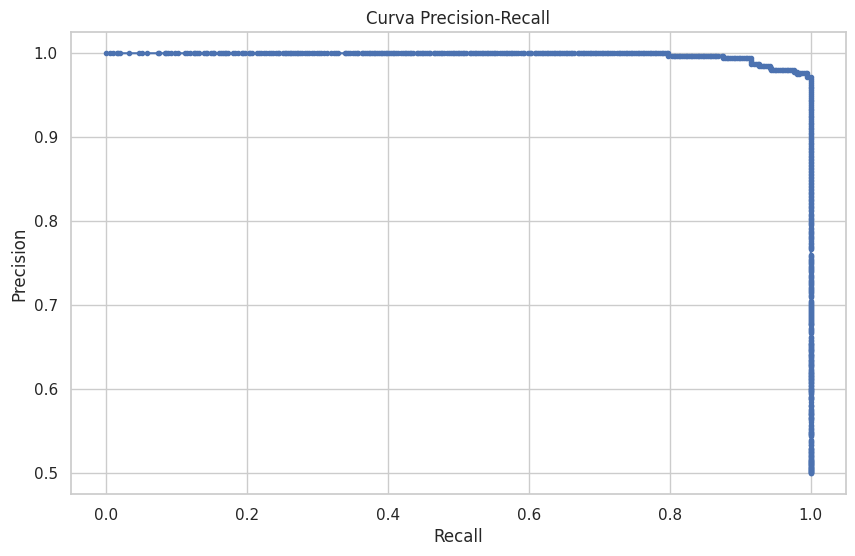

In [14]:
# =============================================
# 7. MODELADO: XGBOOST (CLASIFICACIÓN BINARIA)
# =============================================
def run_xgboost_classifier(df):
    """Modelo para predecir fallecimiento inmediato (<=1 día)"""
    # Selección de características
    features = ['tipo de siniestro', 'vehiculo', 'sexo', 'departamento',
                'año', 'mes', 'hora', 'dia_semana', 'es_fin_de_semana',
                'hora_categoria', 'cluster']
    target = 'objetivo_clasificacion'

    # Preparar datos
    X = df[features].copy()
    y = df[target]

    # One-hot encoding
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Impute NaN values in X_encoded before applying SMOTE
    imputer = SimpleImputer(strategy='most_frequent') # Use most frequent strategy for categorical features
    X_encoded = imputer.fit_transform(X_encoded)

    # Balanceo con SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_encoded, y)

    # División train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
    )

    # Búsqueda de hiperparámetros
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    params = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0]
    }

    grid_search = GridSearchCV(xgb, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Mejor modelo
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Métricas
    print(f"\nMejores parámetros: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2%}")
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.grid(True)
    plt.show()

    return best_model

xgb_model = run_xgboost_classifier(df)

<ipython-input-15-47d6f833b3e8>:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Franjas horarias con más accidentes:
hora_categoria
Tarde        348
Noche        307
Mañana       289
Madrugada    279
dtype: int64


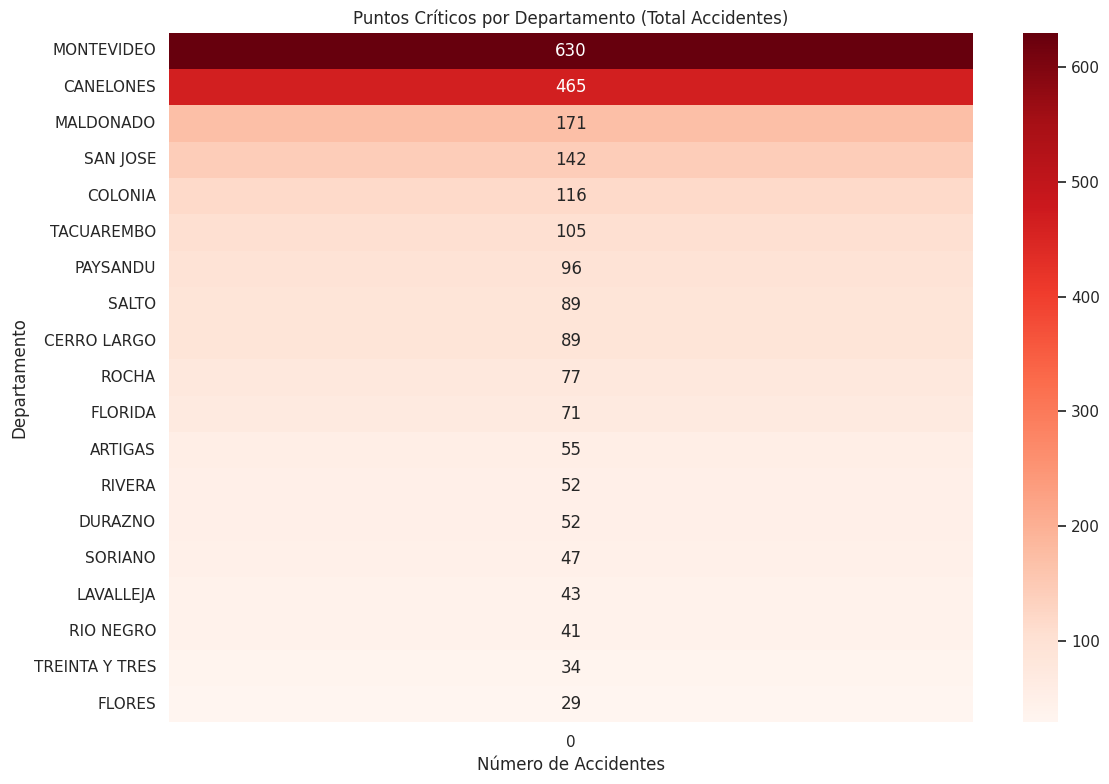

In [15]:
# =============================================
# 8. PLANES DE PREVENCIÓN BASADOS EN DATOS
# =============================================
def generate_prevention_plans(df):
    """Genera recomendaciones de prevención basadas en los análisis"""
    # Estrategias por tipo de siniestro
    top_siniestros = df['tipo de siniestro'].value_counts().nlargest(5).index
    prevention_strategies = {
        'Colisión': ['Control de velocidad', 'Mejor señalización', 'Distanciamiento vehicular'],
        'Atropello': ['Cruces peatonales seguros', 'Reducción velocidad zonas urbanas', 'Educación vial peatones'],
        'Volcamiento': ['Revisiones técnicas vehículos', 'Capacitación conducción segura', 'Mejoramiento de vías'],
        'Caída': ['Protecciones laterales', 'Señalización de peligro', 'Mantenimiento de vías'],
        'Otros': ['Campañas de concientización', 'Refuerzo de leyes de tránsito', 'Tecnología vehicular de seguridad']
    }

    # Visualización de estrategias
    fig = make_subplots(rows=1, cols=5, subplot_titles=top_siniestros)
    for i, siniestro in enumerate(top_siniestros, 1):
        strategies = prevention_strategies.get(siniestro, [])
        fig.add_trace(
            go.Bar(y=strategies, x=[1]*len(strategies), orientation='h', name=siniestro),
            row=1, col=i
        )
    fig.update_layout(title_text='Estrategias de Prevención por Tipo de Siniestro',
                     showlegend=False, height=400)
    fig.show()

    # Medidas por franja horaria crítica
    critical_hours = df.groupby('hora_categoria').size().sort_values(ascending=False)
    print("\nFranjas horarias con más accidentes:")
    print(critical_hours)

    # Puntos críticos por departamento
    plt.figure(figsize=(12, 8))
    critical_points = df.groupby('departamento').size().sort_values(ascending=False)
    sns.heatmap(critical_points.to_frame(), annot=True, fmt="d", cmap="Reds")
    plt.title('Puntos Críticos por Departamento (Total Accidentes)')
    plt.ylabel('Departamento')
    plt.xlabel('Número de Accidentes')
    plt.tight_layout()
    plt.show()

generate_prevention_plans(df)

In [16]:
# =============================================
# 9. GUARDAR RESULTADOS Y MODELOS
# =============================================
# Guardar DataFrame con clusters
df.to_csv('siniestros_con_clusters.csv', index=False, encoding='utf-8')

print("\nAnálisis completado exitosamente. Resultados guardados.")


Análisis completado exitosamente. Resultados guardados.
